In [1]:
from SimPEG import *
from simpegem1d import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
time = np.logspace(-6, -2, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time
)

sig_half = 1e-3
sig_blk = 1e-2
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

630.78313050504


In [3]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (0>LocSigZ) & (-30<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

In [4]:
print (mesh1D)

  ---- 1-D TensorMesh ----  
   x0: 0.00
  nCx: 19
   hx: 1.26,  1.64,  2.14,  2.79,  3.64,  4.74,  6.17,  8.04,  10.47,  13.65,  17.78,  23.16,  30.18,  39.32,  51.23,  66.74,  86.96,  113.29,  147.60,


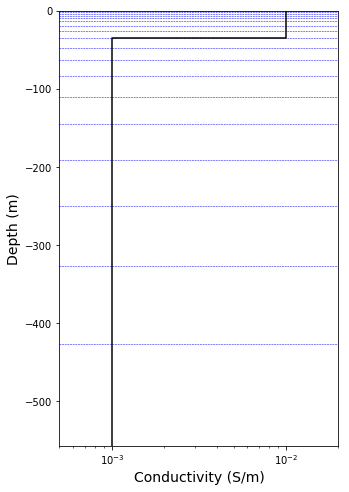

In [5]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [16]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, jacSwitch=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.CondType = 'Real'
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

CPU times: user 148 ms, sys: 3.95 ms, total: 152 ms
Wall time: 151 ms


In [17]:
prob.jacSwitch

False

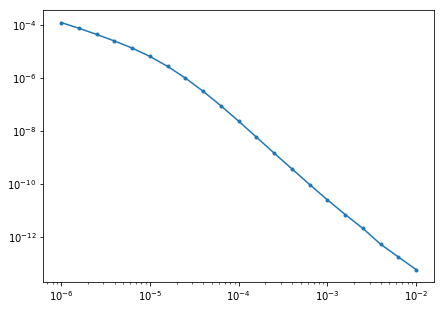

In [18]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [19]:
TDsurvey.dtrue = d_true
std = 0.1
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.15
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor
prob.jacSwitch = True

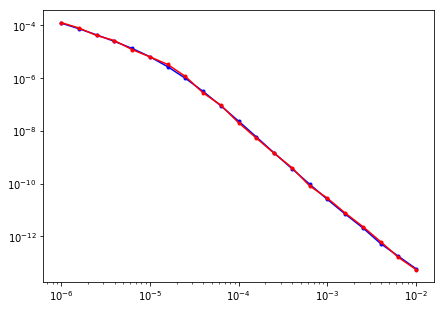

In [20]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, d_true, 'b.-')
axes.plot(TDsurvey.time, TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [21]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./(abs(TDsurvey.dobs)*std+floor)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [22]:
m0 = np.log(np.ones_like(sig)*1e-3)
reg = Regularization.Simple(
    mesh1D
)
opt = Optimization.InexactGaussNewton(maxIter = 10)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [23]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.54e+01  2.33e+02  0.00e+00  2.33e+02    6.07e+01      0              
   1  7.68e+00  1.63e+02  1.42e+00  1.74e+02    3.05e+01      0              
   2  3.84e+00  1.01e+02  5.35e+00  1.21e+02    2.37e+01      0              
   3  1.92e+00  4.29e+01  1.30e+01  6.78e+01    4.31e+01      0              
   4  9.60e-01  2.19e+01  1.85e+01  3.97e+01    6.65e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.3369e+01
1 : |xc-x_last| = 1.2679e+00 

In [24]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :        5
  InexactGaussNewton.doStartIteration     :        5
  InexactGaussNewton.scaleSearchDirection :        5

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 5.13e-03, 9.23e-02,   18x
  EM1D.Jvec_approx                        : 5.32e-03, 9.58e-02,   18x
  InexactGaussNewton.findSearchDirection  : 4.06e-02, 2.03e-01,    5x
  InexactGaussNewton.minimize             : 4.95e+00, 4.95e+00,    1x
  InexactGaussNewton.modifySearchDirection: 9.01e-01, 4.51e+00,    5x
  InexactGaussNewton.projection           : 8.40e-05, 1.93e-03,   23x


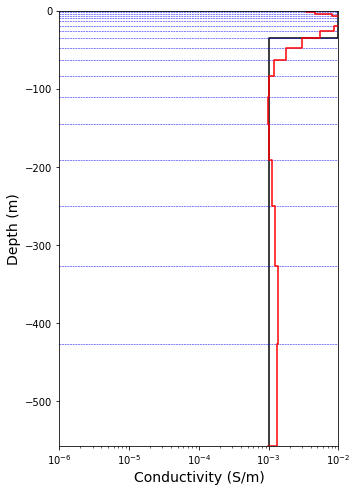

In [25]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e-2), **{'color':'r'})

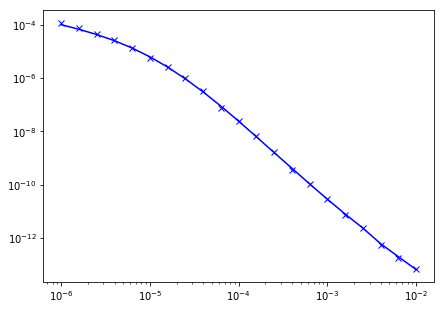

In [157]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, invProb.dpred, 'b-')
axes.plot(TDsurvey.time, TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');

In [107]:
# %%time
# dpredall = []
# maxIter = len(xc)
# prob.jacSwitch = False
# for i in range(maxIter):
#     dpredtemp = TDsurvey.dpred(xc[i])
#     dpredall.append(dpredtemp)

In [56]:
# from JSAnimation import IPython_display
# from matplotlib import animation

# fig, ax = subplots(1,2, figsize=(14, 8))
# ax[0].plot(sig, LocSigZ,  'b.-', lw=2)
# ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
# ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)

# ax[1].plot(TDsurvey.time, -(TDsurvey.dobs), 'r.-', lw=2)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[0].set_xlim(1e-6, 1e-2)


# frame1, = ax[0].plot([], [],  'r.-', lw=2)
# frame2, = ax[1].plot([], [],  'b.-' , lw=2)

# def animate(i_id):
    
#     frame1.set_data(expmap*xc[i_id], LocSigZ)
#     frame2.set_data(TDsurvey.time, -(dpredall[i_id]))
    
#     ax[0].legend(('True', 'Pred'), loc=1, fontsize = 14)
#     ax[1].legend(('True', 'Pred'), loc=1, fontsize = 14)
    
#     ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
#     ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
#     return frame1, frame2

# animation.FuncAnimation(fig, animate, frames=maxIter, interval=40, blit=True)